# Agent-Based Simulation: The Hotelling-Downs Model of Polarization

### Overview
This simulation tries to understand the Hotelling-Downs model of political competition using an ABM. It involves 2 candidates competing for votes on a 1D political spectrum (0 - Political Left, 100 - Political Right)

### Variables
* Voter Tolerance: The maximum distance a voter is willing to reach to support a candidate
* Voter Distribution: The population spread (Uniform, Normal, Beta (Left Skewed)

In [1]:
import mesa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import warnings

warnings.filterwarnings("ignore")

from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

<IPython.core.display.Javascript object>

Could not import SolaraViz. If you need it, install with 'pip install --pre mesa[viz]'


In [2]:
random.seed(42)

### The Voter Agent
* Voters do not move
* Position: A fixed location on the political spectrum (0-100)
* Tolerance: Determines the flexibility of the voter. If a candidate is further away than this value, the voter refuses to vote for them

In [3]:
class Voter(mesa.Agent):
    def __init__(self, unique_id, model, position, tolerance):
        super().__init__(model)
        self.unique_id=unique_id
        self.position = position
        self.tolerance = tolerance

### The Candidate Agent
* Their goal is to maximize their vote share by moving along the political spectrum
* Instead of simply checking for immediate neighbours, the candidate scans in a range of +/- 3 positions, enabling them to see across any potential gaps in the voter distribution.
* Calculates the projected votes for every spot in their scanning radius relative to the opponent's current position and strictly prefers more votes
* In case of a tie, candidate prefers a movement towards the center

In [4]:
class Candidate(mesa.Agent):
    def __init__(self, unique_id, model, name):
        super().__init__(model)
        self.unique_id=unique_id
        self.name = name
        self.vote_count = 0
        self.next_pos = None

    def calculate_votes(self, test_pos):
        opponent = [a for a in self.model.schedule.agents if isinstance(a, Candidate) and a != self][0]
        opp_pos = opponent.pos[0]
        
        votes = 0
        for agent in self.model.schedule.agents:
            if isinstance(agent, Voter):
                dist_me = abs(agent.position - test_pos)
                dist_opp = abs(agent.position - opp_pos)
                
                if dist_me > agent.tolerance: continue
                
                if dist_me < dist_opp: votes += 1
                elif dist_me == dist_opp: votes += 0.5
        return votes

    def step(self):
        current_x = self.pos[0]
        moves = range(max(0, current_x - 3), min(self.model.width, current_x + 4))
        
        best_move = current_x
        max_votes = -1

        for move in moves:
            votes = self.calculate_votes(move)
            if votes > max_votes:
                max_votes = votes
                best_move = move
            elif votes == max_votes:
                if abs(move - 50) < abs(best_move - 50):
                    best_move = move

        if best_move != current_x:
            self.model.grid.move_agent(self, (best_move, 0))

### The Model
* Orchestrates the simulation environment and population generation
* The RandomActivation scheduler shuffles the order of agent execution every step
* The MultiGrid allows Candidates nad Voters to coexist on the same cell
* Initialization: Generates the Voters based on the chosen distribution and places Candidates at the extremes (0 and 100)

In [5]:
class HotellingPolarization(mesa.Model):
    def __init__(self, width=101, num_voters=1000, distribution="uniform", 
                 left_tolerance=100, right_tolerance=100):
        super().__init__()
        self.width = width
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, 1, torus=False) 
        
        positions = []
        for _ in range(num_voters):
            if distribution == "uniform": pos = self.random.randint(0, width - 1)
            elif distribution == "normal": pos = int(np.clip(self.random.gauss(50, 15), 0, width - 1))
            elif distribution == "beta": pos = int(self.random.betavariate(2, 5) * (width - 1))
            positions.append(pos)

        for i, pos in enumerate(positions):
            tol = left_tolerance if pos <= 50 else right_tolerance
            voter = Voter(f"Voter_{i}", self, position=pos, tolerance=tol)
            self.schedule.add(voter)
            self.grid.place_agent(voter, (pos, 0))

        self.schedule.add(Candidate("C_Left", self, "Left"))
        self.grid.place_agent(self.schedule.agents[-1], (0, 0))
        
        self.schedule.add(Candidate("C_Right", self, "Right"))
        self.grid.place_agent(self.schedule.agents[-1], (width-1, 0)) 

        self.datacollector = DataCollector(
            model_reporters={
                "Left_Pos": lambda m: [a.pos[0] for a in m.schedule.agents if isinstance(a, Candidate) and a.name == "Left"][0],
                "Right_Pos": lambda m: [a.pos[0] for a in m.schedule.agents if isinstance(a, Candidate) and a.name == "Right"][0]
            }
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [6]:
def run_and_report(dist, l_tol, r_tol, title):
    model = HotellingPolarization(distribution=dist, left_tolerance=l_tol, right_tolerance=r_tol)
    for _ in range(150):
        model.step()
        
    data = model.datacollector.get_model_vars_dataframe()
    final_l = data["Left_Pos"].iloc[-1]
    final_r = data["Right_Pos"].iloc[-1]
    
    print(f"--- METRICS: {title} ---")
    print(f"Final Left Pos: {final_l}")
    print(f"Final Right Pos: {final_r}")
    print(f"Convergence Gap: {abs(final_r - final_l)}")
    
    plt.figure(figsize=(8, 4))
    plt.plot(data["Left_Pos"], label="Left", color="blue", linewidth=2)
    plt.plot(data["Right_Pos"], label="Right", color="red", linewidth=2)
    
    if dist == "beta": plt.axhline(y=28, color='green', linestyle=':', label="Median (~28)")
    else: plt.axhline(y=50, color='gray', linestyle='--', label="Center (50)")
        
    plt.ylim(-5, 105)
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

### Uniform Distribution with High Tolerance
**Parameters:**
* Distribution - Uniform: Voters are spread evenly across the entire spectrum
* Tolerance (High/High): Both Left and Right voters are extremely flexible and willing to vote for a candidate far from their own position

**Expected Behavior:**
Since voters are highly tolerant, candidates can leave their extremes without fear of losing their base. They will aggressively move toward the center to capture the swing voters. We can expect to see both candidates converge and meet exactly in the middle of the spectrum.

--- METRICS: Uniform: High Tolerance ---
Final Left Pos: 50
Final Right Pos: 50
Convergence Gap: 0


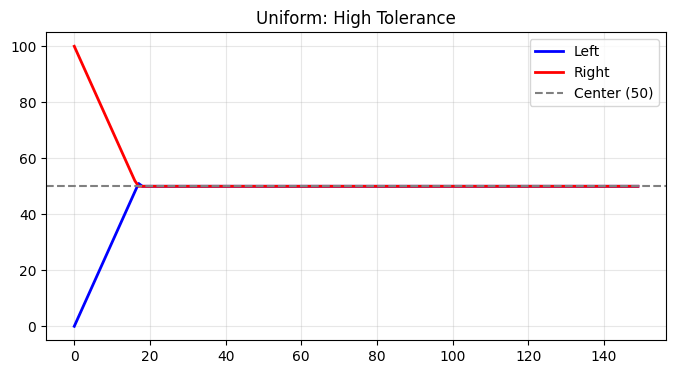

In [7]:
run_and_report("uniform", 100, 100, "Uniform: High Tolerance")

### Uniform Distribution with Low Tolerance
**Parameters:**
* Distribution - Uniform : Voters are spread evenly across the entire spectrum
* Tolerance (Low/Low): Both Left and Right voters are rigid. They will not vote if the candidate moves too far away from them

**Expected Behavior:**
Candidates want to move to the center, but they cannot travel far without alienating their extreme base voters (who are evenly distributed all the way to the edges). We expect the candidates to move inward slightly but then stall, leaving a wide gap between them to maintain support from their respective flanks.

--- METRICS: Uniform: Low Tolerance ---
Final Left Pos: 16
Final Right Pos: 85
Convergence Gap: 69


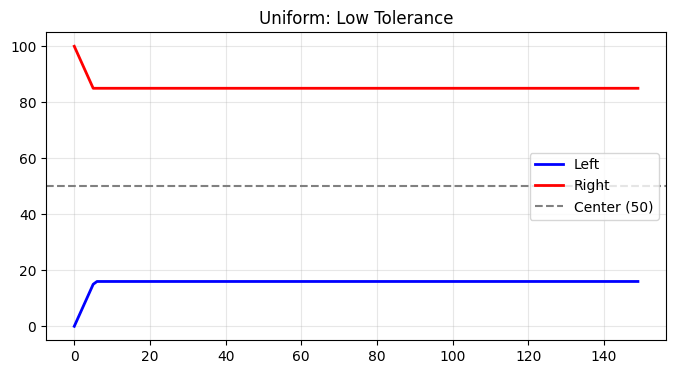

In [8]:
run_and_report("uniform", 15, 15, "Uniform: Low Tolerance")

### Uniform Distribution with Asymmetric Tolerance
**Parameters:**
* Distribution - Uniform : Voters are spread evenly across the entire spectrum
* Tolerance (Low Left / High Right): Left voters are rigid, while Right voters are flexible

**Expected Behavior:**
The Left candidate is restricted by their intolerant base and cannot move far from the edge. The Right candidate, having a flexible base that will support them no matter what, is free to travel across the center line. We expect the Right candidate to invade the Left's territory, capturing the majority of the board.

--- METRICS: Uniform: Asymmetric ---
Final Left Pos: 20
Final Right Pos: 30
Convergence Gap: 10


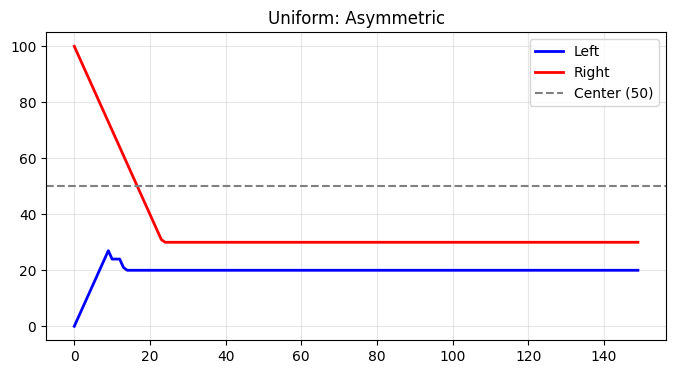

In [9]:
run_and_report("uniform", 20, 100, "Uniform: Asymmetric")

### Normal Distribution with High Tolerance
**Parameters:**
* Distribution - Normal: Voters are clustered around the center (Bell Curve), with very few at the extremes
* Tolerance (High/High): All voters are willing to support distant candidates

**Expected Behavior:**
The voter density is highest in the middle. With high tolerance, there is no penalty for abandoning the sparsely populated fringes. We can expect rapid and stable convergence to the exact peak of the Bell Curve.

--- METRICS: Normal: High Tolerance ---
Final Left Pos: 50
Final Right Pos: 50
Convergence Gap: 0


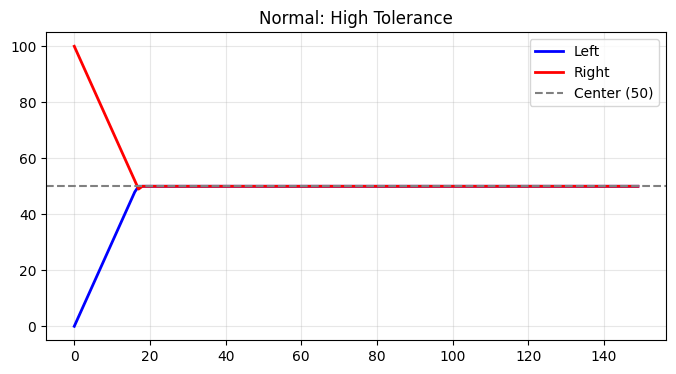

In [10]:
run_and_report("normal", 100, 100, "Normal: High Tolerance")

### Normal Distribution with Low Tolerance
**Parameters:**
* Distribution - Normal: Voters are clustered around the center (Bell Curve), with very few at the extremes
* Tolerance (Low/Low): Voters are rigid and will only vote for nearby candidates.

**Expected Behavior:**
 Unlike the Uniform model, the far edges of the map are essentially empty. Candidates can safely leave the extremes (0 and 100) because there are no voters there to alienate. However, as they approach the peak of the Bell Curve, they will hit a wall of intolerant voters. We can expect them to get closer to the center than in the Uniform case, but still stop short of full convergence.

--- METRICS: Normal: Low Tolerance ---
Final Left Pos: 48
Final Right Pos: 52
Convergence Gap: 4


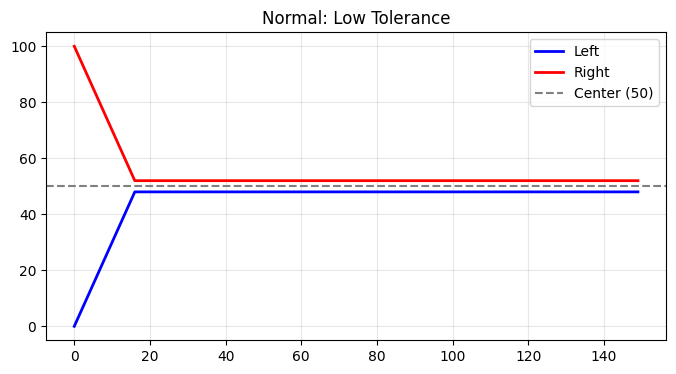

In [11]:
run_and_report("normal", 15, 15, "Normal: Low Tolerance")

### Normal Distribution with Asymmetric Tolerance
**Parameters:**
* Distribution - Normal: Voters are clustered around the center.
* Tolerance (Low Left / High Right): Left voters are rigid, Right voters are flexible.

**Expected Behavior:**
Given the fact that the peak is dense, we can expect a convergence either at the center or slightly at the left, depending on the exact tolerance values

--- METRICS: Normal: Asymmetric ---
Final Left Pos: 51
Final Right Pos: 51
Convergence Gap: 0


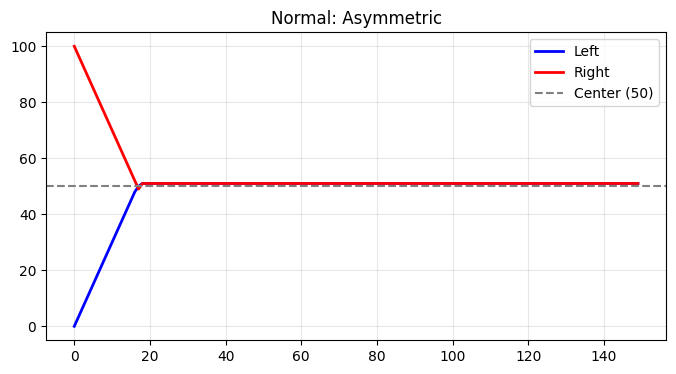

In [12]:
run_and_report("normal", 20, 100, "Normal: Asymmetric")

### Beta Distribution with High Tolerance
**Parameters:**
* Distribution - Beta: The population is heavily skewed to one side (Left-leaning)
* Tolerance (High/High): All voters are flexible

**Expected Behavior:**
We can expect both candidates to ignore the empty right wing and converge at the population median, which will be far to one side of the board.

--- METRICS: Beta: High Tolerance ---
Final Left Pos: 26
Final Right Pos: 26
Convergence Gap: 0


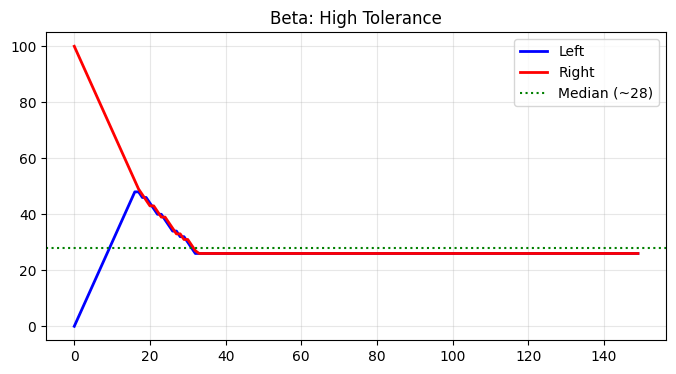

In [13]:
run_and_report("beta", 100, 100, "Beta: High Tolerance")

### Beta Distribution with Low Tolerance
**Parameters:**
* Distribution - Beta: The population is heavily skewed to one side (Left-leaning)
* Tolerance (Low/Low): Voters are rigid.

**Expected Behavior:**
The Left candidate is trapped by the dense, intolerant population on the left. The Right candidate travels through the empty right wing but likely stops as soon as they encounter the first significant cluster of voters. We can expect a large gap, but unlike the Uniform case, the Right candidate will be stuck much closer to the center, while the Left remains pinned to the edge.

--- METRICS: Beta: Low Tolerance ---
Final Left Pos: 19
Final Right Pos: 36
Convergence Gap: 17


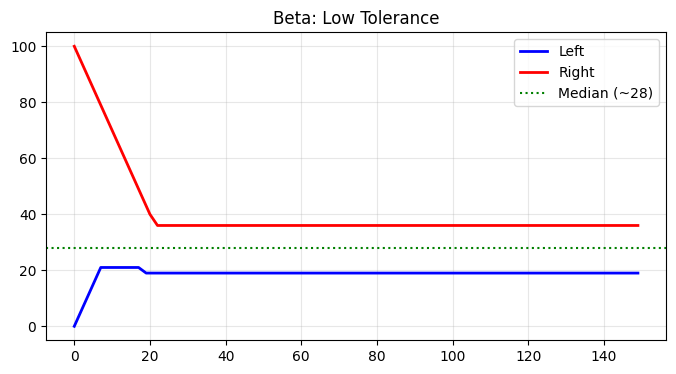

In [14]:
run_and_report("beta", 15, 15, "Beta: Low Tolerance")

### Beta Distribution with Asymmetric Tolerance
**Parameters:**
* Distribution - Beta: The population is heavily skewed to one side (Left-leaning)
* Tolerance (Low Left / High Right): Left voters are rigid, Right voters are flexible.

**Expected Behavior:**
The Left candidate is pinned down by the massive, rigid left-wing population. The Right candidate has no voters on the right to lose and a flexible base. We expect the Right candidate to cross the entire map to sit directly next to the Left candidate, effectively capturing nearly all voters to their right.

--- METRICS: Beta: Asymmetric ---
Final Left Pos: 24
Final Right Pos: 26
Convergence Gap: 2


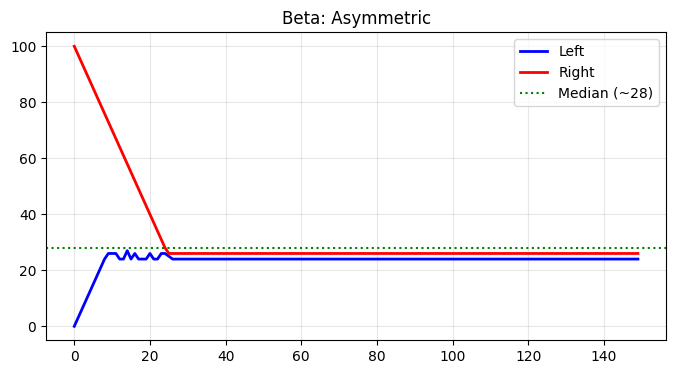

In [15]:
run_and_report("beta", 20, 100, "Beta: Asymmetric")